<a href="https://colab.research.google.com/github/emarkou/multilingual-bert-text-classification/blob/master/mBert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import time
import numpy as np
import pandas as pd

import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler
from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers import get_linear_schedule_with_warmup

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name == '/device:GPU:0':
    print(f'Found GPU at: {device_name}')

Found GPU at: /device:GPU:0


In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('GPU in use:', torch.cuda.get_device_name(0))
else:
    print('using the CPU')
    device = torch.device("cpu")

GPU in use: Tesla T4


In [ ]:
MAX_LEN = 128 # max sequences length
batch_size = 32

In [ ]:
# extra preprocessing steps
# prepend CLS and append SEP, truncate, pad

labels_encoding = {
    "CCAT": 0,
    "ECAT": 1,
    "GCAT": 2,
    "MCAT": 3
}

def preprocessing(df):
    sentences = df.sentence.values
    labels = np.array([labels_encoding[l] for l in df.label.values])

    tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=True)
    
    encoded_sentences = []
    for sent in sentences:
        encoded_sent = tokenizer.encode(
                            sent,
                            add_special_tokens = True,
                            truncation=True,
                            max_length = MAX_LEN
                    )
        
        encoded_sentences.append(encoded_sent)
    encoded_sentences = pad_sequences(encoded_sentences, maxlen=MAX_LEN, dtype="long", 
                            value=0, truncating="post", padding="post")
    return encoded_sentences, labels
    
def attention_masks(encoded_sentences):
    # attention masks, 0 for padding, 1 for actual token
    attention_masks = []
    for sent in encoded_sentences:
        att_mask = [int(token_id > 0) for token_id in sent]
        attention_masks.append(att_mask)
    return attention_masks

In [ ]:
# load the datasets
df = pd.read_csv("./english.train.10000", delimiter='\t', header=None, names=['label', 'sentence'])
df_test = pd.read_csv("./english.dev", delimiter='\t', header=None, names=['label', 'sentence'])

In [ ]:
df.head()

,label,sentence
0,ECAT,France could make more tax cuts than planned i...
1,ECAT,"Ryan, Beck & Co said it won $2.679 million of ..."
2,MCAT,Brazilian shares plummeted more than 3.0 perce...
3,GCAT,Boris Becker said after beating Jan Siemerink ...
4,GCAT,Leading stories in the Greek financial press: ...


In [ ]:
train_encoded_sentences, train_labels = preprocessing(df)
train_attention_masks = attention_masks(train_encoded_sentences)

test_encoded_sentences, test_labels = preprocessing(df_test)
test_attention_masks = attention_masks(test_encoded_sentences)

In [ ]:
train_inputs = torch.tensor(train_encoded_sentences)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_attention_masks)

validation_inputs = torch.tensor(test_encoded_sentences)
validation_labels = torch.tensor(test_labels)
validation_masks = torch.tensor(test_attention_masks)

In [ ]:
# data loader for training
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = SequentialSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# data loader for validation
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:

import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels = 4,   
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

optimizer = AdamW(model.parameters(),
                  lr = 3e-5, 
                  eps = 1e-8, 
                  weight_decay = 0.01
                )

epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # 10% * datasetSize/batchSize
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [ ]:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

def compute_accuracy(preds, labels):
    p = np.argmax(preds, axis=1).flatten()
    l = labels.flatten()
    return np.sum(p==l)/len(l)

def run_train(epochs):
    losses = []
    for e in range(epochs):
        print('======== Epoch {:} / {:} ========'.format(e + 1, epochs))
        start_train_time = time.time()
        total_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):

            if step%10 == 0:
                elapsed = time.time()-start_train_time
                print(f'{step}/{len(train_dataloader)} --> Time elapsed {elapsed}')

            # input_data, input_masks, input_labels = batch
            input_data = batch[0].to(device)
            input_masks = batch[1].to(device)
            input_labels = batch[2].to(device)

            model.zero_grad()

            # forward propagation
            out = model(input_data,
                        token_type_ids = None, 
                        attention_mask = input_masks,
                        labels = input_labels)
            
            loss = out[0]
            total_loss = total_loss + loss.item()

            # backward propagation
            loss.backward()
            
            torch.nn.utils.clip_grad_norm(model.parameters(), 1)

            optimizer.step()
        
        epoch_loss = total_loss/len(train_dataloader)
        losses.append(epoch_loss)
        print(f"Training took {time.time()-start_train_time}")

        # Validation
        start_validation_time = time.time()
        model.eval()
        eval_loss, eval_acc = 0,0
        for step, batch in enumerate(validation_dataloader):
            batch = tuple(t.to(device) for t in batch)
            eval_data, eval_masks, eval_labels = batch
            with torch.no_grad():
                out = model(eval_data,
                            token_type_ids = None, 
                            attention_mask=eval_masks)
            logits = out[0]

            #  Uncomment for GPU execution
            logits = logits.detach().cpu().numpy()
            eval_labels = eval_labels.to('cpu').numpy()
            batch_acc = compute_accuracy(logits, eval_labels)

            # Uncomment for CPU execution
            # batch_acc = compute_accuracy(logits.numpy(), eval_labels.numpy())

            eval_acc += batch_acc
        print(f"Accuracy: {eval_acc/(step+1)}, Time elapsed: {time.time()-start_validation_time}")
    return losses
            

In [ ]:
losses = run_train(epochs)

======== Epoch 1 / 3 ========
0/313 --> Time elapsed 0.001956462860107422


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:40: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


10/313 --> Time elapsed 6.9794535636901855
20/313 --> Time elapsed 14.00432801246643
30/313 --> Time elapsed 21.007280588150024
40/313 --> Time elapsed 28.093219757080078
50/313 --> Time elapsed 35.22671961784363
60/313 --> Time elapsed 42.34084105491638
70/313 --> Time elapsed 49.51961612701416
80/313 --> Time elapsed 56.761051654815674
90/313 --> Time elapsed 64.05973291397095
100/313 --> Time elapsed 71.35890173912048
110/313 --> Time elapsed 78.66858291625977
120/313 --> Time elapsed 86.04460859298706
130/313 --> Time elapsed 93.50694799423218
140/313 --> Time elapsed 101.0357723236084
150/313 --> Time elapsed 108.52301597595215
160/313 --> Time elapsed 116.03029012680054
170/313 --> Time elapsed 123.58999395370483
180/313 --> Time elapsed 131.18279719352722
190/313 --> Time elapsed 138.8018410205841
200/313 --> Time elapsed 146.473863363266
210/313 --> Time elapsed 154.1548933982849
220/313 --> Time elapsed 161.85852766036987
230/313 --> Time elapsed 169.602641582489
240/313 --> T

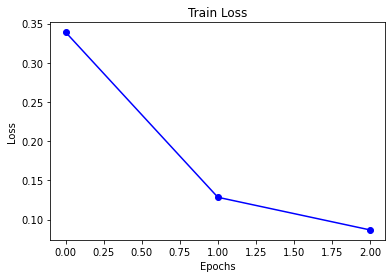

In [ ]:
# plot losses
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns 

plt.plot(losses, 'b-o')
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
# torch.cuda.memory_summary(device=None, abbreviated=False)

In [ ]:
import os 

output_dir = './model_save'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
# tokenizer.save_pretrained(output_dir)

In [ ]:
def run_test(df_test):

    test_encoded_sentences, test_labels = preprocessing(df_test)
    test_attention_masks = attention_masks(test_encoded_sentences)

    test_inputs = torch.tensor(test_encoded_sentences)
    test_labels = torch.tensor(test_labels)
    test_masks = torch.tensor(test_attention_masks)

    test_data = TensorDataset(test_inputs, test_masks, test_labels)
    test_sampler = SequentialSampler(test_data)
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

    model.eval()
    eval_loss, eval_acc = 0,0
    for step, batch in enumerate(test_dataloader):
        batch = tuple(t.to(device) for t in batch)
        eval_data, eval_masks, eval_labels = batch
        with torch.no_grad():
            out = model(eval_data,
                        token_type_ids = None,
                        attention_mask=eval_masks)
        logits = out[0]
        logits = logits.detach().cpu().numpy()
        eval_labels = eval_labels.to('cpu').numpy()
        batch_acc = compute_accuracy(logits, eval_labels)
        eval_acc += batch_acc
    print(f"Accuracy: {eval_acc/(step+1)}")

In [ ]:
print("Evaluating on english \n")
df_test = pd.read_csv("./english.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

print("Evaluating on spanish \n")
df_test = pd.read_csv("./spanish.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

print("Evaluating on french \n")
df_test = pd.read_csv("./french.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

print("Evaluating on italian \n")
df_test = pd.read_csv("./italian.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

print("Evaluating on japanese \n")
df_test = pd.read_csv("./japanese.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

print("Evaluating on russian \n")
df_test = pd.read_csv("./russian.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

print("Evaluating on german \n")
df_test = pd.read_csv("./german.test", delimiter='\t', header=None, names=['label', 'sentence'])
run_test(df_test)

Evaluating on english 

Accuracy: 0.965
Evaluating on spanish 

Accuracy: 0.73425
Evaluating on french 

Accuracy: 0.78025
Evaluating on italian 

Accuracy: 0.65675
Evaluating on japanese 

Accuracy: 0.714
Evaluating on russian 

Accuracy: 0.62825
Evaluating on german 

Accuracy: 0.7905
